# Author: Sanjay Kazi

## Task_7: Stock Market Prediction using Numerical and Textual Analysis

### Objectivet:
- Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines 


### Stock to analyze and predict 
- SENSEX (S&P BSE SENSEX)

### Data:
- Download historical stock prices from https://in.finance.yahoo.com/
- Download textual (news) data from https://bit.ly/36fFPI6

# ***GRIP*** @ The Spark Foundation

# Importing libraries

In [86]:
#import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt  #Altair is a declarative statistical visualization library for Python

import statsmodels.api as sm 

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

# For time stamps
from datetime import datetime
# Import the libraries
import os
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [87]:
#ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

##  Load Textual Data [Times of India News Headline]

In [88]:
# Load the first dataset
columns=['Date','Category','News']
ndf = pd.read_csv("india-news-headlines.csv",names=columns)

In [89]:
ndf = ndf.rename({'Date': 'date'}, axis=1)

In [90]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424068 entries, 0 to 3424067
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   date      object
 1   Category  object
 2   News      object
dtypes: object(3)
memory usage: 78.4+ MB


In [91]:
ndf.head()

,date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [92]:
ndf.shape

(3424068, 3)

In [93]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
ndf.head(-5)

,date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3424058,20201231,50 NRIs reach Singhu; offer help to farmers
3424059,20201231,Navjot Singh Sidhu tweets apology; says 'wore ...
3424060,20201231,Azim Premji organisation's name misused to che...
3424061,20201231,Get govt nod to probe officials: MP to agencies


In [9]:
ndf.shape

(3424067, 2)

## Load Stock Price Data [SENSEX]

In [10]:

# Load the second dataset
hisdf = pd.read_csv("BSESN1.csv")
hisdf.head(-5)
hisdf = hisdf.drop(['ticker', 'Unnamed: 0'], axis= 1)


In [11]:

hisdf.head()

,date,open,high,low,close,adjclose,volume
0,2015-12-14,24935.599609,25194.150391,24867.730469,25150.349609,25150.349609,11600.0
1,2015-12-15,25186.679688,25342.779297,25075.539062,25320.439453,25320.439453,9700.0
2,2015-12-16,25402.470703,25572.900391,25372.470703,25494.369141,25494.369141,10800.0
3,2015-12-17,25596.630859,25831.310547,25448.320312,25803.779297,25803.779297,22700.0
4,2015-12-18,25764.669922,25789.509766,25481.509766,25519.220703,25519.220703,10400.0


### Making the timestamp

In [12]:
ndf["date"] = pd.to_datetime(ndf["date"],format='%Y%m%d')
hisdf["date"] = pd.to_datetime(hisdf["date"],format='%Y-%m-%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 78.4+ MB


### Group headlines for each day

In [14]:
ndf['News'] = ndf.groupby(['date']).transform(lambda x : ' '.join(x)) 
ndf = ndf.drop_duplicates() 
ndf.reset_index(inplace=True,drop=True)

In [15]:
ndf

,date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [16]:
ndf.shape

(7262, 2)

In [17]:
# Check for any duplicated values
ndf.isnull().sum()

date    0
News    0
dtype: int64

In [18]:
hisdf.shape

(1332, 7)

In [19]:
hisdf.describe()

,open,high,low,close,adjclose,volume
count,1326.000000,1326.000000,1326.000000,1326.000000,1326.000000,1.326000e+03
mean,34758.554760,34925.826718,34507.507923,34712.363910,34712.363910,2.548759e+05
std,6431.024477,6458.709370,6370.308619,6416.676472,6416.676472,2.045641e+06
min,23060.390625,23142.960938,22494.609375,22951.830078,22951.830078,0.000000e+00
25%,29528.917969,29699.907715,29382.348145,29578.267578,29578.267578,1.060000e+04
50%,34859.675781,35069.246094,34679.705078,34856.701172,34856.701172,1.435000e+04
75%,38644.843750,38808.597656,38354.355469,38541.369141,38541.369141,1.970000e+04
max,52400.031250,52516.761719,51886.460938,52154.128906,52154.128906,3.181510e+07


## Ckecking for Null values

In [20]:
# Check for duplicated values
hisdf.isnull().sum()

date        0
open        6
high        6
low         6
close       6
adjclose    6
volume      6
dtype: int64

In [21]:
len(hisdf)

1332

### Dropping Null values

In [52]:
hisdf.dropna(inplace = True)
len(hisdf)

1326

# Let's see the stock price trend

Text(0, 0.5, 'BSESN')

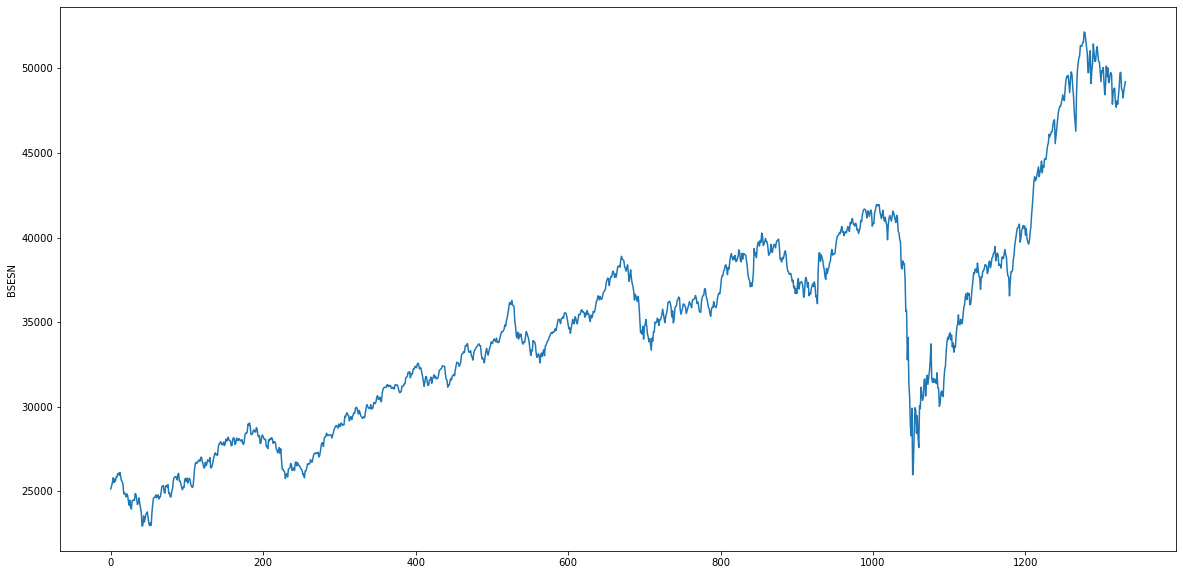

In [94]:
plt.figure(figsize=(20,10))
hisdf['close'].plot()
plt.ylabel('BSESN')

### Removing Unnecessary characters

In [23]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

# Historical stock price Analysis

## Let's visualise the Moving Average

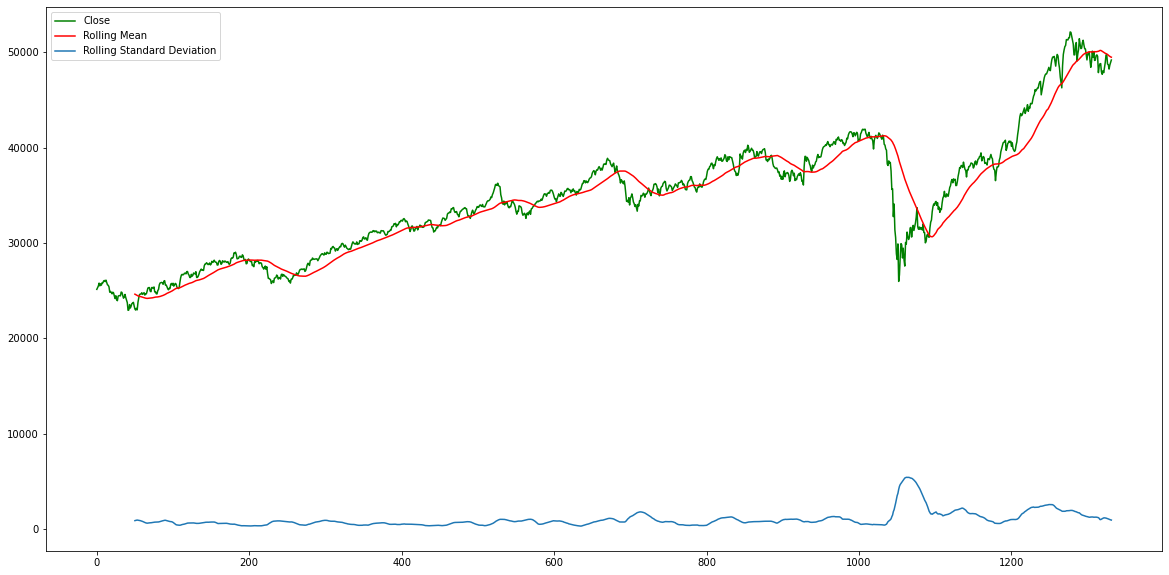

In [42]:
#Plotting moving average
close = hisdf['close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window =50).std()

plt.figure(figsize=(20,10))
hisdf['close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

## Return Plot

Text(0.5, 1.0, 'Returns')

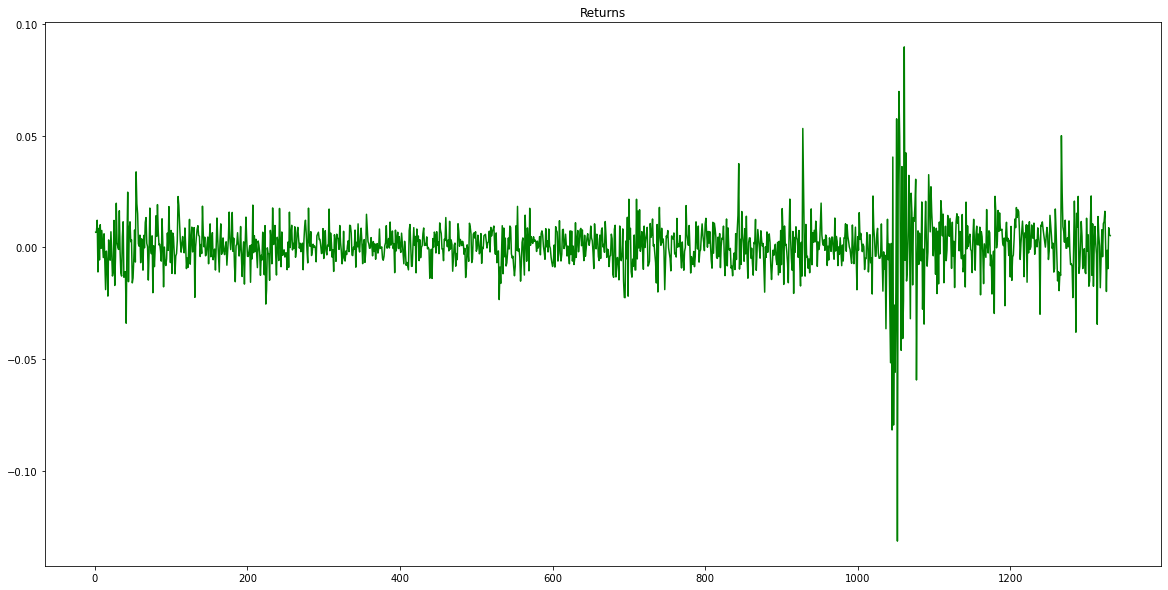

In [43]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

### Training and splitting the data

In [53]:
# Train test split
train = hisdf[:1316]
test = hisdf[1316:]

# Stationarity Test

## Rolling mean and standaerd deviation

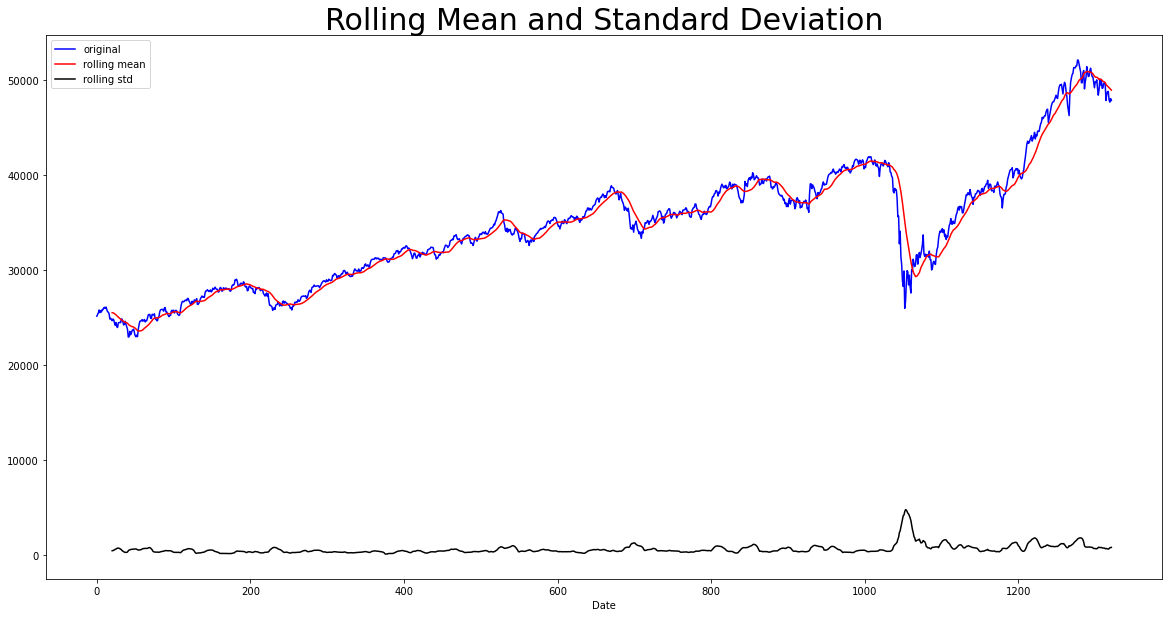

Results of dickey fuller test
ADF Test Statistic : -0.7941907757508472
p-value : 0.8208225302088366
#Lags Used : 11
Number of Observations Used : 1304
Weak evidence against null hypothesis, time series is non-stationary 


In [54]:
#Stationarity test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

 #Determine the rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (20,10))
 plt.plot(timeseries, color = 'blue', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'black', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")

test_stationarity(train['close'])

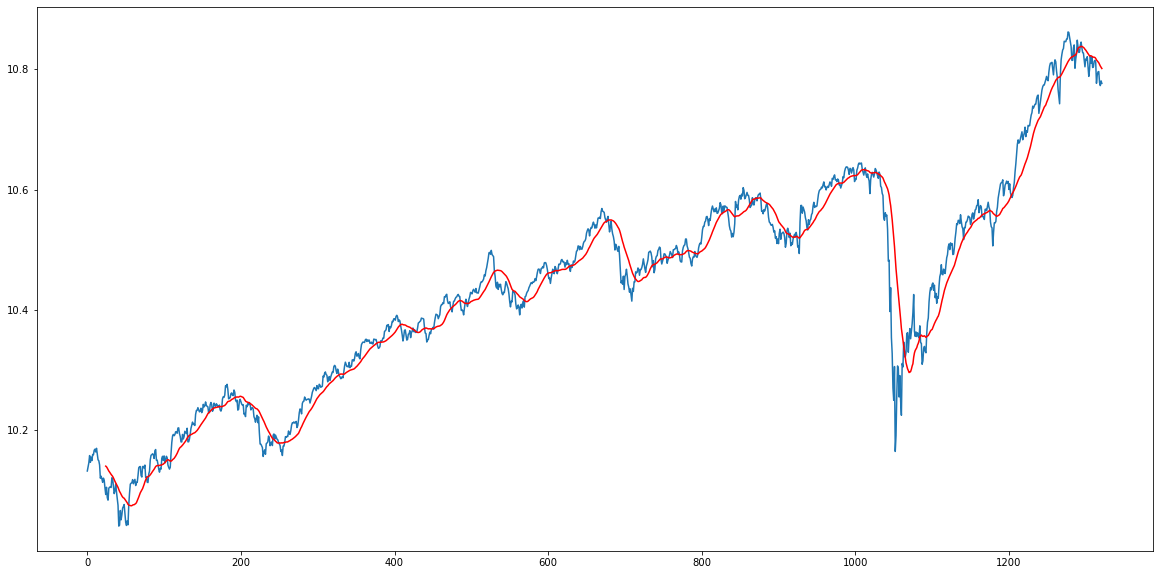

In [55]:
train_log = np.log(train['close']) 
test_log = np.log(test['close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (20,10))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

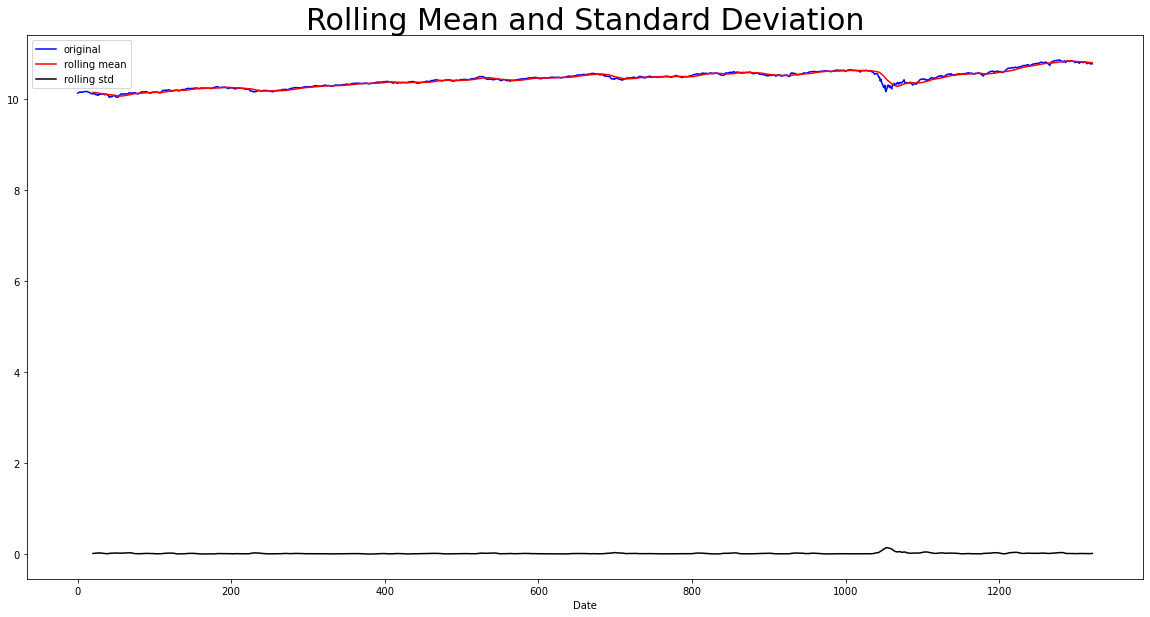

Results of dickey fuller test
ADF Test Statistic : -1.0735800126831088
p-value : 0.725492092062336
#Lags Used : 12
Number of Observations Used : 1303
Weak evidence against null hypothesis, time series is non-stationary 


In [56]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

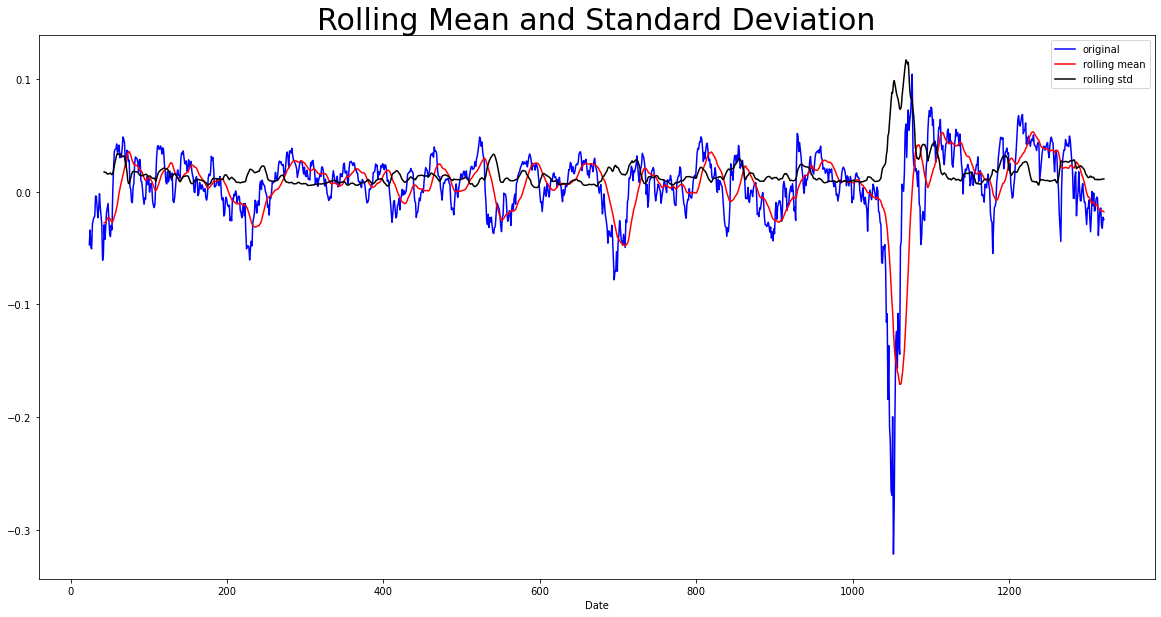

Results of dickey fuller test
ADF Test Statistic : -7.127383244504689
p-value : 3.5907952370359097e-10
#Lags Used : 12
Number of Observations Used : 1280
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [57]:

train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

## Using auto_arima to make the prediction model using log data

In [58]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima

In [59]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
print(predictions.shape)
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7947.099, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7950.329, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7952.118, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7951.900, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7950.050, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7951.013, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7950.517, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7950.099, Time=1.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7951.587, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 4.690 seconds
(10,)


Text(0, 0.5, 'Actual Stock Price')

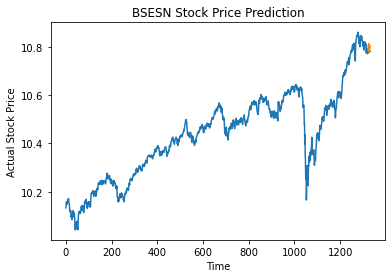

In [60]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')


## Calculating error

In [61]:
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.021482533996289556


## Textual Analysis

In [62]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [63]:
ndf.shape

(7262, 2)

In [64]:

#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930


In [65]:

#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

In [66]:
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]
ndf['Negative'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]
ndf['Neutral'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]
ndf

,date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978,-0.9997,0.132,0.787,0.082
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405,-0.9998,0.143,0.758,0.098
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775,-0.9999,0.154,0.748,0.098
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930,-0.9999,0.150,0.764,0.086


## Merging the two datasets

In [67]:
df_merge = pd.merge(hisdf, ndf, how='inner', on='date')
df_merge

,date,open,high,low,close,adjclose,volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-12-14,24935.599609,25194.150391,24867.730469,25150.349609,25150.349609,11600.0,things men do that make women fall deeper i...,0.472105,0.100389,-0.9996,0.153,0.719,0.128
1,2015-12-15,25186.679688,25342.779297,25075.539062,25320.439453,25320.439453,9700.0,Do looks matter at workplace Common running m...,0.421103,0.074733,-0.9999,0.149,0.745,0.106
2,2015-12-16,25402.470703,25572.900391,25372.470703,25494.369141,25494.369141,10800.0,In pics foods that make you smarter Dos and...,0.434933,0.111113,-0.9724,0.107,0.786,0.107
3,2015-12-17,25596.630859,25831.310547,25448.320312,25803.779297,25803.779297,22700.0,sex secrets every woman must know You too ca...,0.389598,0.058890,-0.9997,0.150,0.735,0.115
4,2015-12-18,25764.669922,25789.509766,25481.509766,25519.220703,25519.220703,10400.0,Stop making THESE diet disasters How to get s...,0.412045,0.071201,-0.9999,0.161,0.726,0.113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,2020-12-24,46743.488281,47053.398438,46539.019531,46973.539062,46973.539062,13700.0,How to set the mood for sex during cold winter...,0.387011,0.053569,-0.9988,0.096,0.833,0.071
1238,2020-12-28,47153.589844,47406.718750,47148.238281,47353.750000,47353.750000,9600.0,Horoscope Today December Check astro...,0.409973,0.071405,-0.9998,0.143,0.758,0.098
1239,2020-12-29,47466.621094,47714.550781,47361.898438,47613.078125,47613.078125,12800.0,Man recovers charred remains of 'thief' from h...,0.415684,0.060775,-0.9999,0.154,0.748,0.098
1240,2020-12-30,47789.031250,47807.851562,47358.359375,47746.218750,47746.218750,15600.0,Numerology Readings December Predicti...,0.436863,0.046930,-0.9999,0.150,0.764,0.086


In [68]:
ndf.columns

Index(['date', 'News', 'Subjectivity', 'Polarity', 'Compound', 'Negative',
       'Neutral', 'Positive'],
      dtype='object')

In [69]:
df_merge.shape

(1242, 14)

## Createing Dataframe for model training 

In [70]:
dfmerge1 = df_merge[['close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,25150.349609,0.472105,0.100389,-0.9996,0.153,0.719,0.128
1,25320.439453,0.421103,0.074733,-0.9999,0.149,0.745,0.106
2,25494.369141,0.434933,0.111113,-0.9724,0.107,0.786,0.107
3,25803.779297,0.389598,0.058890,-0.9997,0.150,0.735,0.115
4,25519.220703,0.412045,0.071201,-0.9999,0.161,0.726,0.113
...,...,...,...,...,...,...,...
1237,46973.539062,0.387011,0.053569,-0.9988,0.096,0.833,0.071
1238,47353.750000,0.409973,0.071405,-0.9998,0.143,0.758,0.098
1239,47613.078125,0.415684,0.060775,-0.9999,0.154,0.748,0.098
1240,47746.218750,0.436863,0.046930,-0.9999,0.150,0.764,0.086


## Normalizing data

In [71]:

scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.088652,1.000000,0.804262,0.000200,0.496063,0.131034,0.839080
1,0.095510,0.639257,0.618084,0.000050,0.464567,0.310345,0.586207
2,0.102524,0.737077,0.882084,0.013803,0.133858,0.593103,0.597701
3,0.115000,0.416426,0.503113,0.000150,0.472441,0.241379,0.689655
4,0.103526,0.575193,0.592454,0.000050,0.559055,0.179310,0.666667


In [72]:
df = df.reset_index()
X=df.drop('close',axis=1)
X

,index,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0,1.000000,0.804262,0.000200,0.496063,0.131034,0.839080
1,1,0.639257,0.618084,0.000050,0.464567,0.310345,0.586207
2,2,0.737077,0.882084,0.013803,0.133858,0.593103,0.597701
3,3,0.416426,0.503113,0.000150,0.472441,0.241379,0.689655
4,4,0.575193,0.592454,0.000050,0.559055,0.179310,0.666667
...,...,...,...,...,...,...,...
1237,1237,0.398128,0.464499,0.000600,0.047244,0.917241,0.183908
1238,1238,0.560540,0.593934,0.000100,0.417323,0.400000,0.494253
1239,1239,0.600934,0.516791,0.000050,0.503937,0.331034,0.494253
1240,1240,0.750727,0.416327,0.000050,0.472441,0.441379,0.356322


In [73]:
Y=df['close']
Y

0       0.088652
1       0.095510
2       0.102524
3       0.115000
4       0.103526
          ...   
1237    0.968637
1238    0.983968
1239    0.994425
1240    0.999794
1241    1.000000
Name: close, Length: 1242, dtype: float64

## Splitting the dataset into train and test dataset

In [74]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(993, 7)

## RandomForestRegressor

In [75]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [76]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[0.64042367 0.15386341 0.21043851 0.56715973 0.07064893 0.61509676
 0.4294422  0.36110265 0.41937245 0.52720958]
1032    0.677184
124     0.144101
184     0.218569
914     0.548845
18      0.075534
1145    0.619313
1090    0.372941
443     0.335970
466     0.432820
741     0.524652
Name: close, dtype: float64
Mean Squared error:  0.00026108906396863724


## DecisionTreeRegressor

In [77]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

In [78]:
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[0.62330497 0.15276763 0.22020851 0.55537044 0.07661445 0.59321757
 0.45388905 0.34840218 0.42384482 0.53156231]
1032    0.677184
124     0.144101
184     0.218569
914     0.548845
18      0.075534
1145    0.619313
1090    0.372941
443     0.335970
466     0.432820
741     0.524652
Name: close, dtype: float64
Mean Squared error:  0.00044031517791204847


## AdaBoostRegressor

In [79]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

AdaBoostRegressor()

In [80]:
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.002484551372426067


## LGBMRegressor

In [81]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)

LGBMRegressor()

In [82]:
predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.000445871472508589


## XGBRegressor

In [83]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.000358669541528282


# Summary

- So far trying various models we observe that RandomForestRegressor model is most robust as it's Mean Squared Error is least.

- Many parameters also can be applied to achieve more robustness.

# Thank You! :)